# Predicting the Quality of Vinho Verde Wine Based on Physical Properties
## DSCI 100 Project Final Report
Date: November/December 2022

Group: 157

## Proposal Overview
- Introduction
- Methods & Results
- Discussion
- References

***
### *For our purposes only - remove this cell before handing in project!!*

To do

[X] Introduction

[] Methods & Results

[] Add titles and legends to all figures and tables

[] Discussion

[] References

[] Check for typos/proofread

***

## Introduction

There are many factors that give white wine its distinctive taste. Sweetness is determined by **residual sugars** left over from fermentation, and is measured in grams per decimeter cubed. The sugars that were consumed during fermentation determine the **alcohol content** of the wine – grapes with more sugar create more alcoholic wines. The tart or sour taste of the wine comes from its **acidity**. All wine has a **pH** between 3 and 4, but small variations in acidity can create a big difference in taste. Other properties such as **citric acid**, **sulfur dioxide**, **chlorides**, and **sulfates** also affect the quality of the wine.

In our project, we ask, what physical properties lead to a higher quality white wine? To solve this problem, we will be using data from approximately 5,000 variants of the Portuguese wine “Vinho Verde” collected by Cortez et al. (2009). 

Though all variables provided affect the quality of a wine, we chose a subset of the variables based on which appeared to have an obvious relationship with quality (summarized in the following section) in addition to what was of interest to us. The variables we will be using in our analysis of white wine quality are:
- Fixed acidity (g/dm^3)
- Citric acid (g/dm^3)
- Residual sugar (g/dm^3)
- pH (logarithmic units, from 1-12)
- Alcohol (volume percent, from 0 to 100)
- Quality (a score, from 3-9, with 9 being the best quality)

## Methods & Results

"Describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis."

#### Importing relevant libraries

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Importing data from the web

In [2]:
data <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
wine <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", delim = ";")

Rows: 4898 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Tidying the data

In [9]:
wine <- mutate(wine, quality = as_factor(quality))
colnames(wine) <- make.names(colnames(wine))
head(wine)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6


#### Splitting the data

In [5]:
wine_split <- initial_split(wine, prop = 0.75, strata = quality)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)

#### Summarizing the data in tables

In [49]:
#Variables available to us
#colnames(wine)

# Get the number of samples and their respective percentage of each quality in the training set
number_of_samples <- group_by(wine_training, quality) |> summarize(n = n())
total_samples <- pull(number_of_samples, n) |> sum()
number_of_samples <- mutate(number_of_samples, percent = round(100 * n / total_samples, digits = 1))
"Table 1. Proportion of wines of each quality in the dataset"
number_of_samples

[1] "Table 1. Proportion of wines of each quality in the dataset"

quality,n,percent
<fct>,<int>,<dbl>
3,14,0.4
4,124,3.4
5,1091,29.7
6,1647,44.9
7,662,18.0
8,131,3.6
9,3,0.1


**Table 1** shows the number of observations for each quality of wine and their proportion of the dataset for the training data.

In [48]:
# See the average value of each variable for each quality of wine
fixed.acidity_column <- group_by(wine_training, quality) |> 
    summarize(fixed.acidity.avg = mean(fixed.acidity))

volatile.acidity_column <- group_by(wine_training, quality) |> 
    summarize(volatile.acidity.avg = mean(volatile.acidity)) |>
    select(-quality)

citric.acid_column <- group_by(wine_training, quality) |> 
    summarize(citric.acid.avg = mean(citric.acid)) |>
    select(-quality)

residual.sugar_column <- group_by(wine_training, quality) |> 
    summarize(residual.sugar.avg = mean(residual.sugar)) |>
    select(-quality)

chlorides_column <- group_by(wine_training, quality) |> 
    summarize(chlorides.avg = mean(chlorides)) |>
    select(-quality)

free.sulfur.dioxide_column <- group_by(wine_training, quality) |> 
    summarize(free.sulfur.dioxide.avg = mean(free.sulfur.dioxide)) |>
    select(-quality)

density_column <- group_by(wine_training, quality) |> 
    summarize(density.avg = mean(density)) |>
    select(-quality)

pH_column <- group_by(wine_training, quality) |> 
    summarize(pH.avg = mean(pH)) |>
    select(-quality)

sulphates_column <- group_by(wine_training, quality) |> 
    summarize(sulphates.avg = mean(sulphates)) |>
    select(-quality)

alcohol_column <- group_by(wine_training, quality) |> 
    summarize(alcohol.avg = mean(alcohol)) |>
    select(-quality)

quality_averages <- bind_cols(fixed.acidity_column, volatile.acidity_column, citric.acid_column,
                              residual.sugar_column, chlorides_column, free.sulfur.dioxide_column, 
                              density_column, pH_column, sulphates_column, alcohol_column)

"Table 2. Average value of each variable for each quality of wine"
quality_averages

[1] "Table 2. Average value of each variable for each quality of wine"

quality,fixed.acidity.avg,volatile.acidity.avg,citric.acid.avg,residual.sugar.avg,chlorides.avg,free.sulfur.dioxide.avg,density.avg,pH.avg,sulphates.avg,alcohol.avg
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,7.707143,0.2982143,0.3400000,5.664286,0.04100000,55.53571,0.9944593,3.203571,0.4500000,10.371429
4,7.172581,0.3801613,0.3033871,4.439516,0.04918548,24.07661,0.9943026,3.187661,0.4753226,10.140726
5,6.934922,0.3020669,0.3345280,7.337122,0.05151421,36.32631,0.9952745,3.170898,0.4796609,9.797812
6,6.835398,0.2603188,0.3402247,6.491044,0.04475471,35.76412,0.9939570,3.187766,0.4897086,10.573275
7,6.731495,0.2622432,0.3245015,5.319789,0.03850453,34.58837,0.9925097,3.210091,0.5012840,11.338620
8,6.600763,0.2798855,0.3275573,5.101527,0.03774809,35.32824,0.9918322,3.228855,0.4785496,11.774809
9,7.533333,0.3300000,0.3600000,5.466667,0.02466667,36.33333,0.9921500,3.296667,0.4766667,11.833333


**Table 2** shows the average value for each variable for each quality of wine. This allowed us to gain a broad overview of how variables change as wine quality changes. We selected variables for our analysis based on how much they changed with quality as well as what elements we found interesting.

#### Visualizing the data

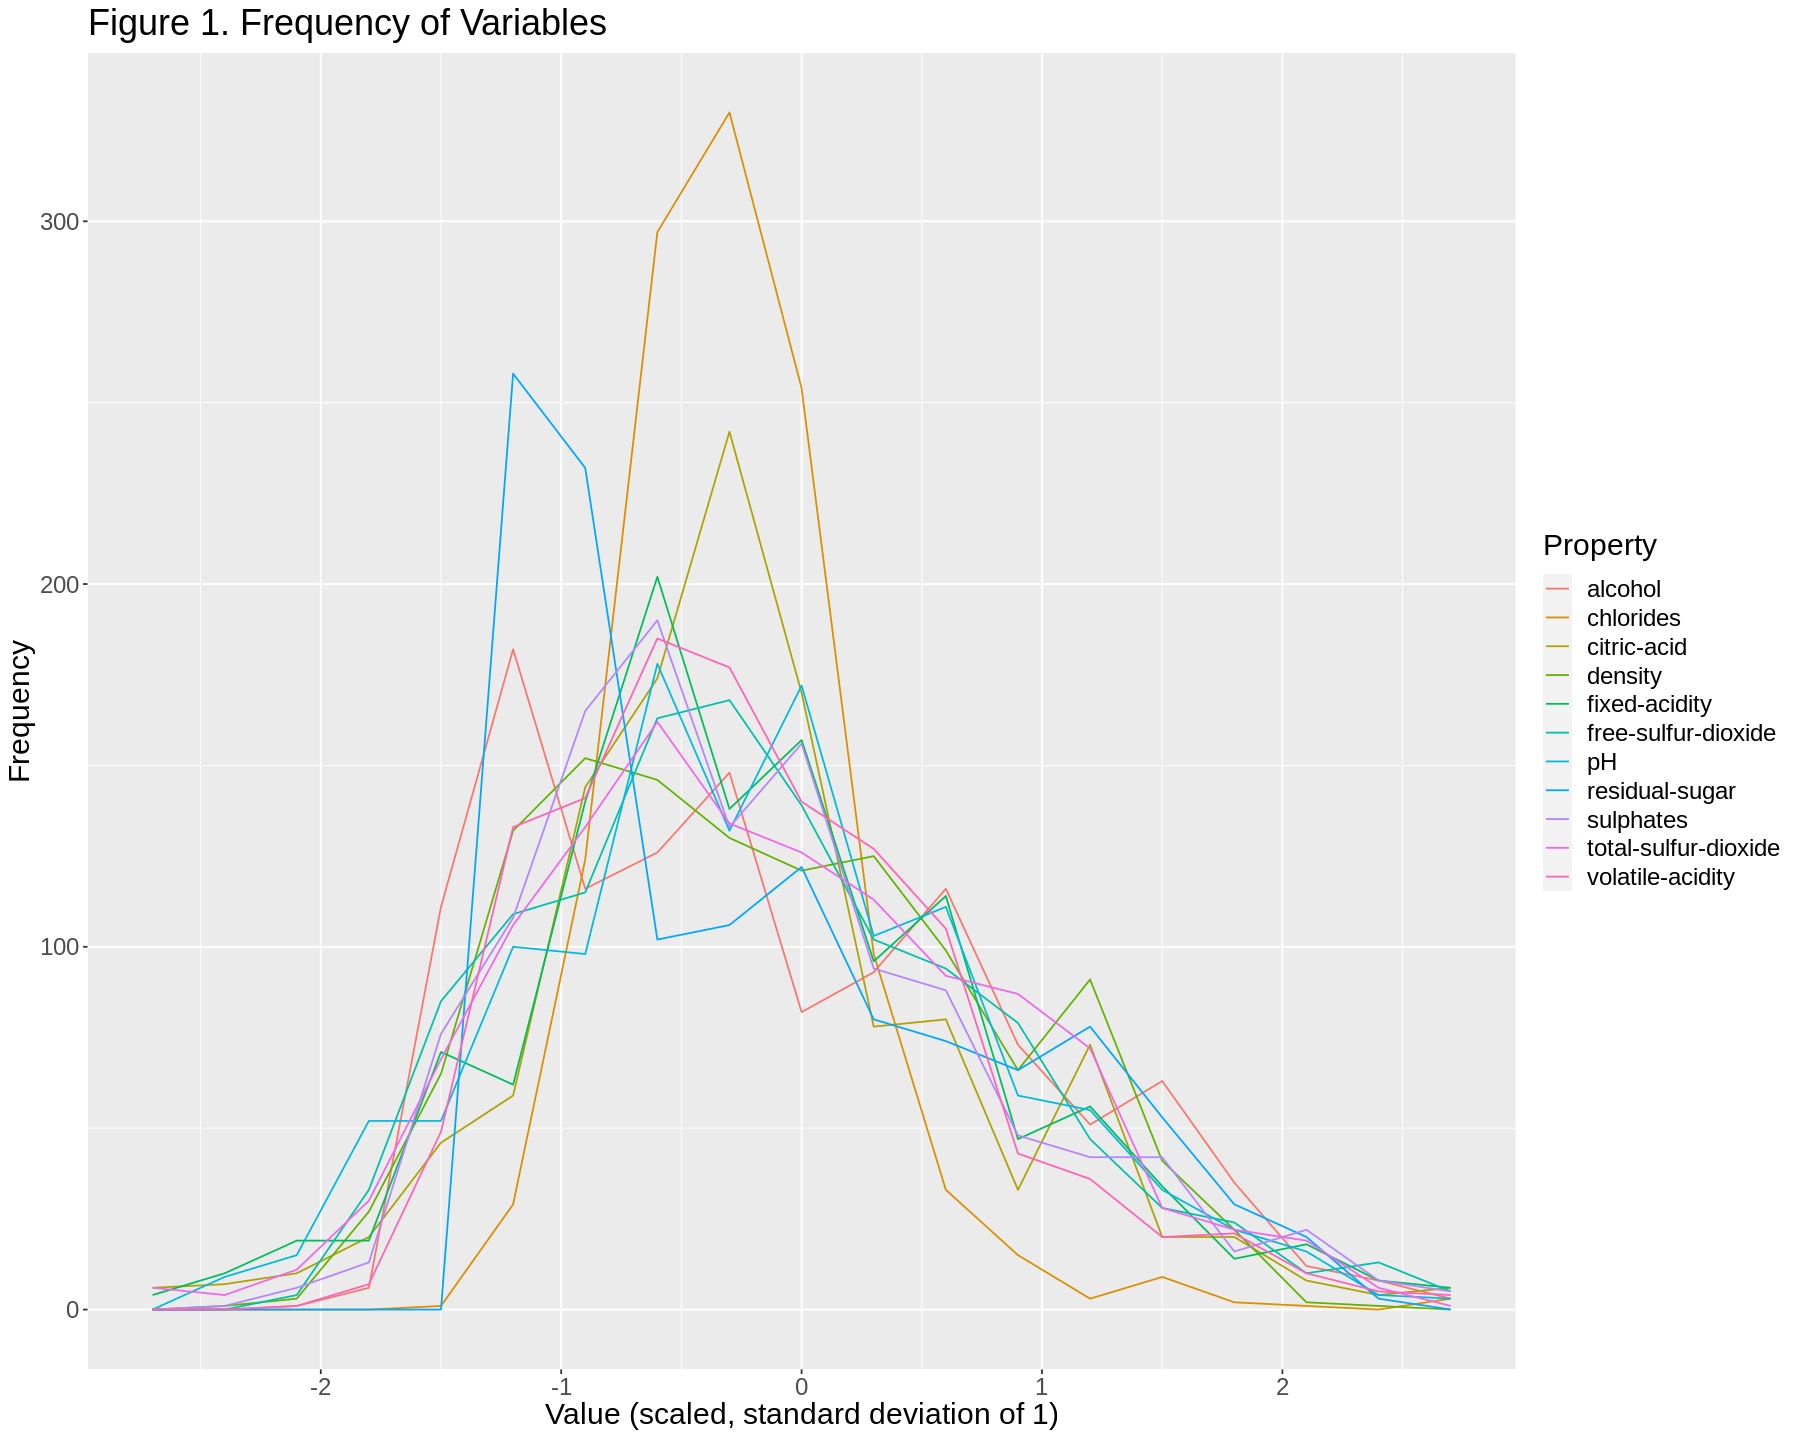

In [47]:
wine_scaled <- select(wine_testing, fixed.acidity:alcohol)
wine_scaled <- scale(wine_scaled)
breaks = seq(-3, 3, by=0.3)
wine_scaled <- as.data.frame(wine_scaled)
x1 <- table(cut(wine_scaled$fixed.acidity, breaks))
x2 <- table(cut(wine_scaled$volatile.acidity, breaks))
x3 <- table(cut(wine_scaled$citric.acid, breaks))
x4 <- table(cut(wine_scaled$residual.sugar, breaks))
x5 <- table(cut(wine_scaled$chlorides, breaks))
x6 <- table(cut(wine_scaled$free.sulfur.dioxide, breaks))
x7 <- table(cut(wine_scaled$total.sulfur.dioxide, breaks))
x8 <- table(cut(wine_scaled$density, breaks))
x9 <- table(cut(wine_scaled$pH, breaks))
x10 <- table(cut(wine_scaled$sulphates, breaks))
x11 <- table(cut(wine_scaled$alcohol, breaks))

wine_frequency <- data.frame(rbind(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11))
wine_frequency <- data.frame(t(wine_frequency[-1]))
wine_frequency$Value <- c(seq(-2.7, 2.7, by=0.3))

colnames(wine_frequency) <- c(
    "fixed-acidity",
    "volatile-acidity",
    "citric-acid",
    "residual-sugar",
    "chlorides",
    "free-sulfur-dioxide",
    "total-sulfur-dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
    "Value")

wine_frequency <- pivot_longer(wine_frequency, 
    cols = "fixed-acidity":"alcohol",
    names_to = "Property",
    values_to = "Frequency")

options(repr.plot.width = 15, repr.plot.height = 12)
wine_plot <- ggplot(wine_frequency, aes(x = Value, y = Frequency, colour = Property)) +
    geom_line() +
    xlab("Value (scaled, standard deviation of 1)") +
    theme(text = element_text(size = 18)) +
    ggtitle("Figure 1. Frequency of Variables")

wine_plot

**Figure 1** shows ... ADD SHORT DESCRIPTION!

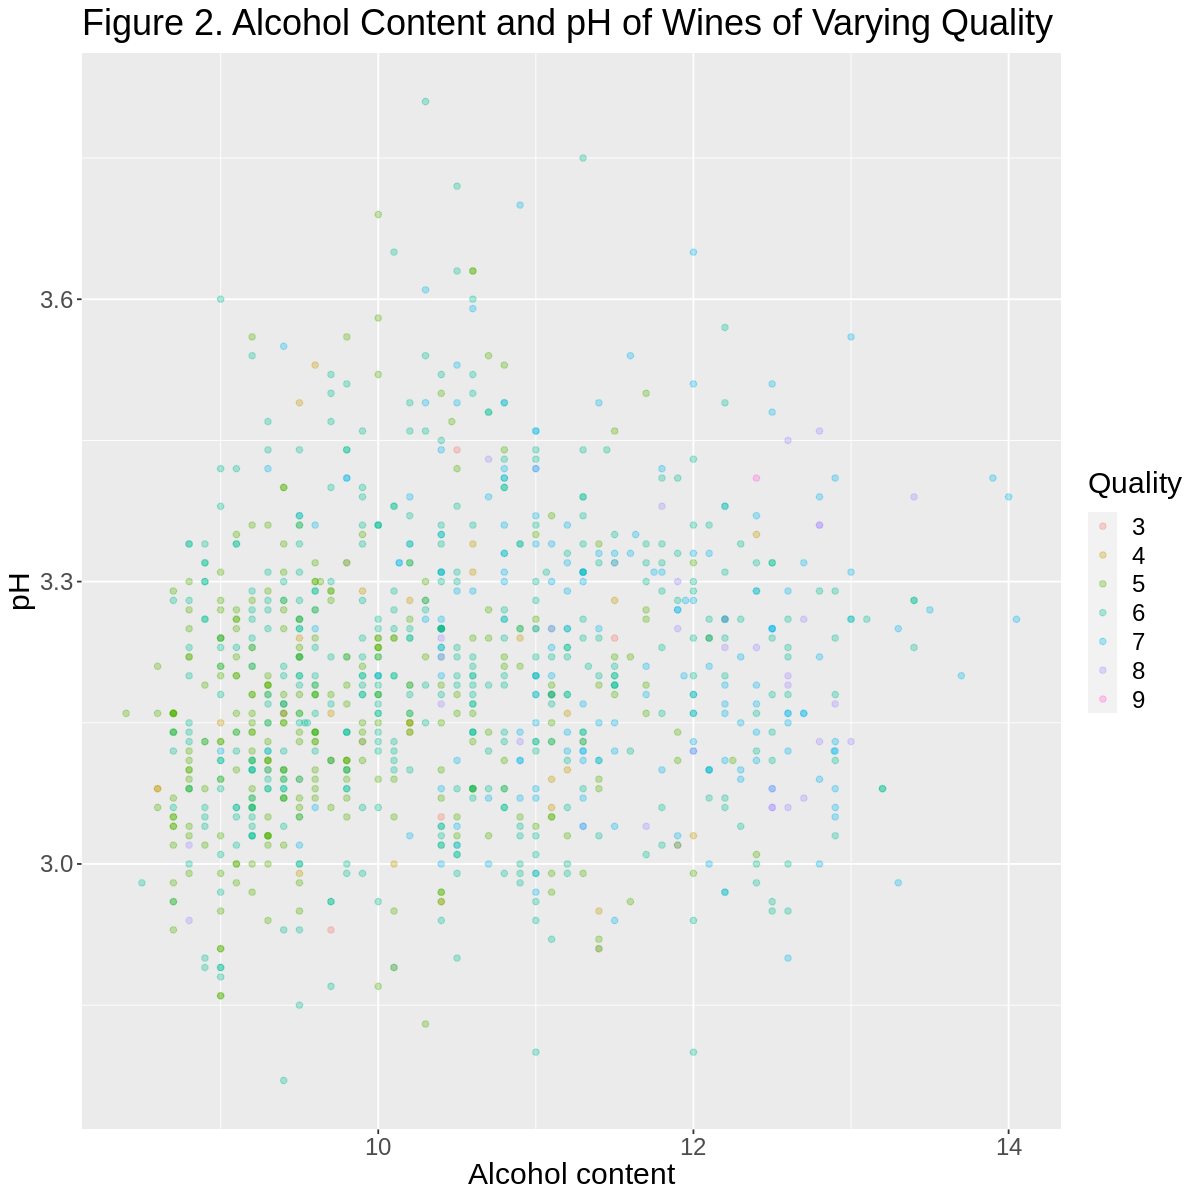

In [51]:
# Alcohol content, pH, and rating

small_training <- rep_sample_n(wine_training, size = 1000)

options(repr.plot.width = 10, repr.plot.height = 10)

alcohol_ph_plot <- ggplot(small_training, aes(x = alcohol, y = pH, colour = quality)) +
    geom_point(alpha = 0.3) +
    labs(x = "Alcohol content", y = "pH", colour = "Quality") +
    theme(text = element_text(size = 18)) +
    ggtitle("Figure 2. Alcohol Content and pH of Wines of Varying Quality")

alcohol_ph_plot

**Figure 2** shows how wine quality changes as the variables pH and alcohol content change for a subset of the training data. Wines with higher alcohol content receive higher ratings. pH does not have as drastic of an effect, though some wines with higher pH have lower quality scores.

Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


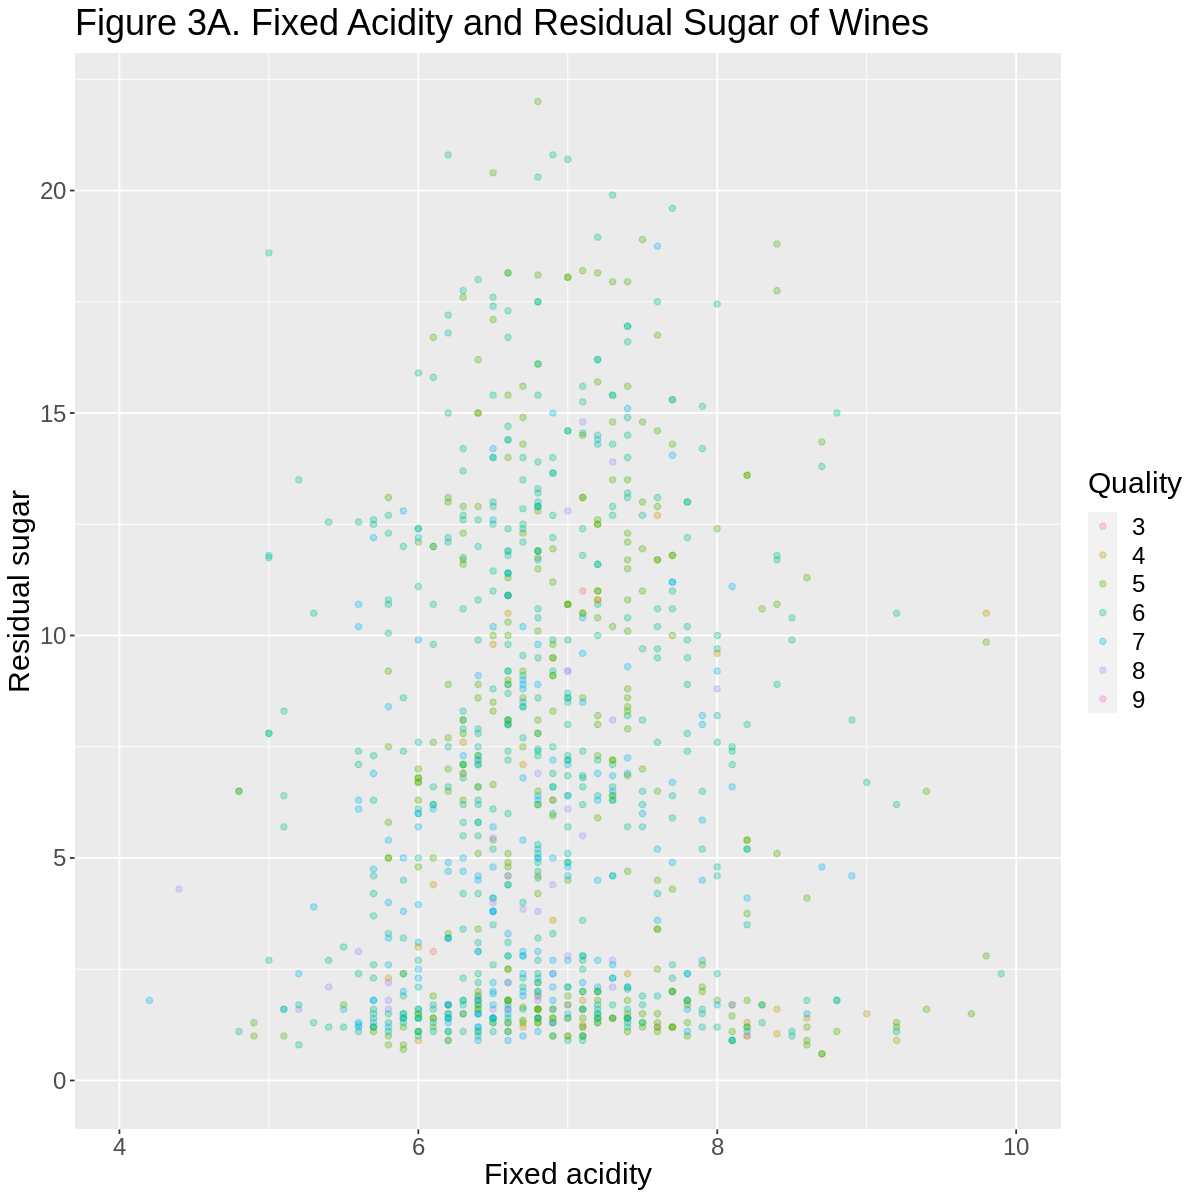

Warning message:
“Removed 1 rows containing missing values (geom_point).”


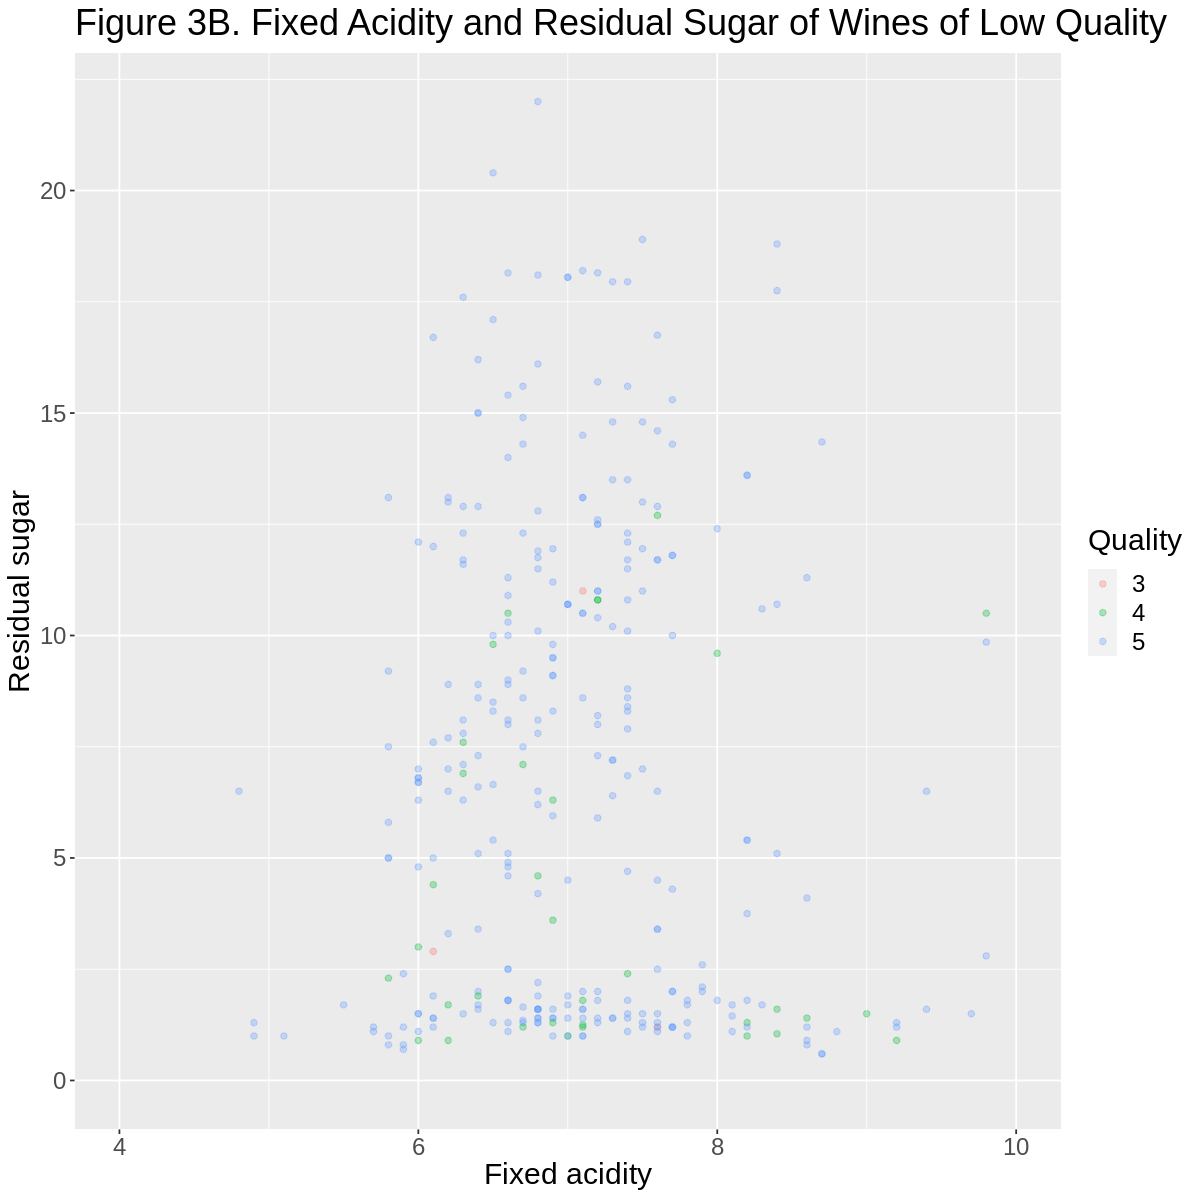

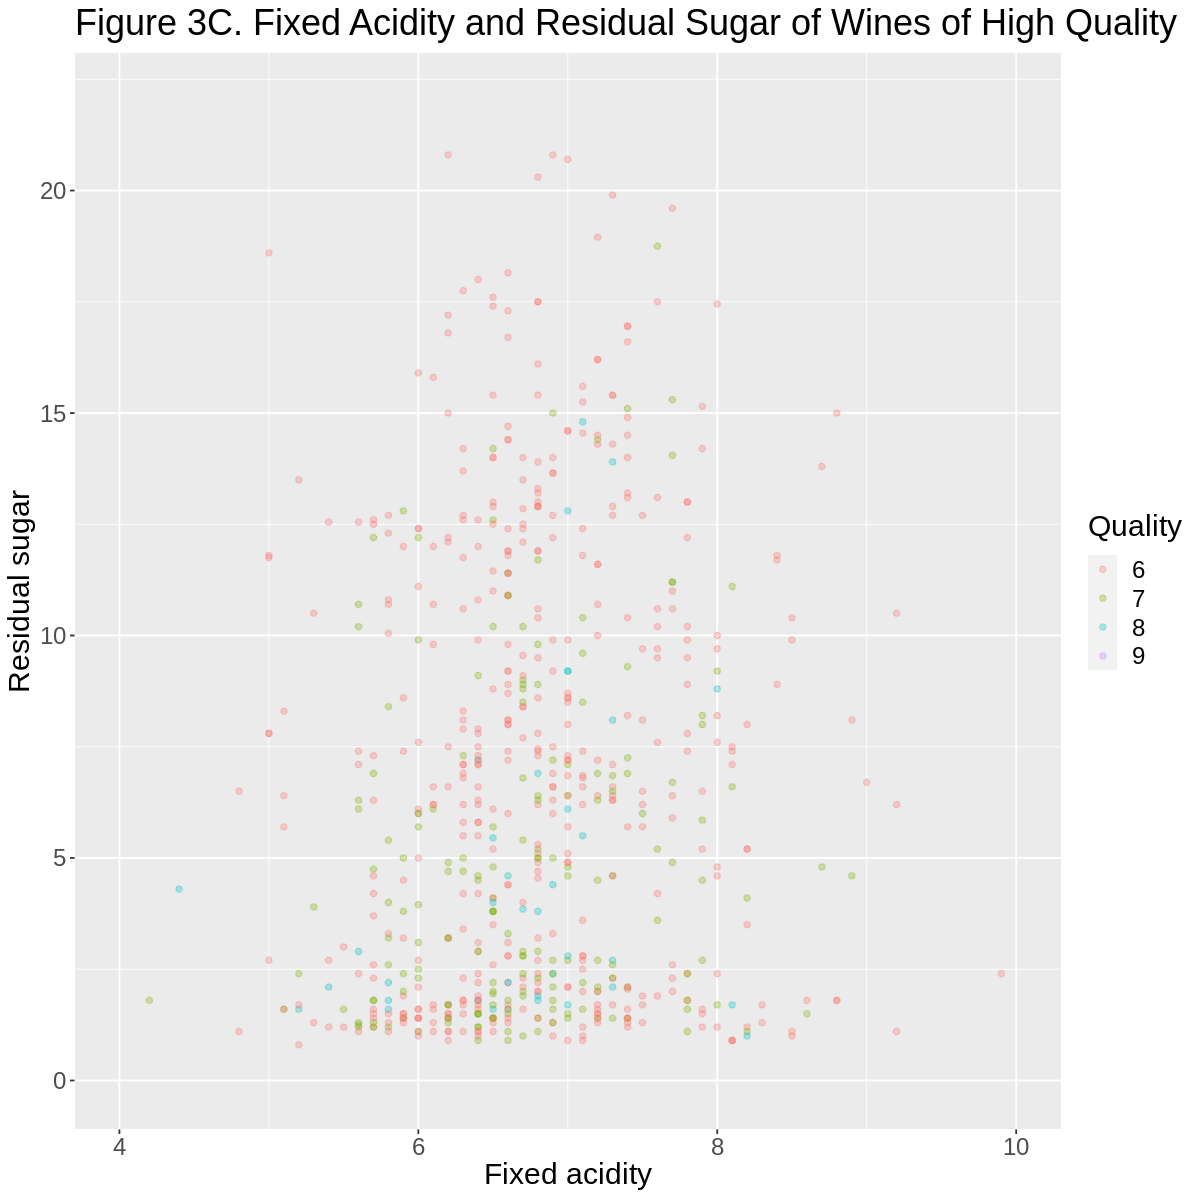

In [69]:
# Fixed acidity, residual sugar, and rating

options(repr.plot.width = 10, repr.plot.height = 10)

acid_sugar_plot <- ggplot(small_training, aes(x = fixed.acidity, y = residual.sugar, colour = quality)) +
    geom_point(alpha = 0.3) +
    labs(x = "Fixed acidity", y = "Residual sugar", colour = "Quality") +
    theme(text = element_text(size = 18)) +
    ggtitle("Figure 3A. Fixed Acidity and Residual Sugar of Wines") +
    xlim(4, 10) +
    ylim(0, 22)

acid_sugar_plot
bad_sugar <- filter(small_training, quality == "3" | quality == "4" | quality == "5")
good_sugar <- filter(small_training, quality == "6" | quality == "7" | quality == "8" | quality == "9")

bad_sugar_plot <- ggplot(bad_sugar, aes(x = fixed.acidity, y = residual.sugar, colour = quality)) +
    geom_point(alpha = 0.3) +
    labs(x = "Fixed acidity", y = "Residual sugar", colour = "Quality") +
    theme(text = element_text(size = 18)) +
    ggtitle("Figure 3B. Fixed Acidity and Residual Sugar of Wines of Low Quality") +
    xlim(4, 10) +
    ylim(0, 22)

bad_sugar_plot

good_sugar_plot <- ggplot(good_sugar, aes(x = fixed.acidity, y = residual.sugar, colour = quality)) +
    geom_point(alpha = 0.3) +
    labs(x = "Fixed acidity", y = "Residual sugar", colour = "Quality") +
    theme(text = element_text(size = 18)) +
    ggtitle("Figure 3C. Fixed Acidity and Residual Sugar of Wines of High Quality") +
    xlim(4, 10) +
    ylim(0, 22)

good_sugar_plot

**Figure 3A** shows how wine quality changes for a subset of the training data as the variables fixed acidity and residual sugar change. Many wines with higher fixed acidity have lower quality scores. The trends for residual sugars are hard to determine. **Figure 3B and 3C** split this data into low (≤ 5) and high (≥ 6) quality wines to better see possible trends. Higher quality wines appear to have a more balanced (in the middle) residual sugar profile.

#### Designing the model

In [50]:
# kfold split

# knn model